In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  Lasso
from sklearn.ensemble import  RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import KNNImputer, SimpleImputer

In [2]:
data = pd.read_csv('BigCitiesHealth.csv')

In [3]:
data.shape

(148292, 31)

In [4]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,value_90_ci_low,value_90_ci_high
count,1.471950e+05,147522.000000,148292.000000,93378.000000,93388.000000,0.0,0.0
mean,2.880322e+06,830.377923,2015.227996,468.838106,568.740516,NaN,NaN
std,1.697827e+06,4304.120276,3.112534,1742.895189,2043.575501,NaN,NaN
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320,NaN,NaN
25%,8.200000e+05,10.851578,2013.000000,9.337966,15.449973,NaN,NaN
50%,2.938000e+06,26.743773,2015.000000,23.259248,34.061614,NaN,NaN
75%,4.748000e+06,77.161225,2018.000000,109.929802,149.434371,NaN,NaN
max,5.553000e+06,99408.000000,2020.000000,22650.600880,29193.761110,NaN,NaN


In [5]:

data.dtypes

metric_item_label                   object
metric_cat_label                    object
metric_subcat_label                 object
metric_item_label_subtitle          object
metric_cat_item_yaxis_label         object
metric_source_desc_label_fn         object
metric_source_desc_label_url_fn     object
geo_label_city                      object
geo_label_state                     object
geo_label_citystate                 object
geo_fips_code                      float64
value                              float64
date_label                           int64
geo_label_proxy_or_real             object
geo_label_proxy_footnote            object
geo_fips_desc                       object
date_label_proxy_or_real            object
date_label_proxy_footnote           object
value_ci_flag_yesno                 object
value_95_ci_low                    float64
value_95_ci_high                   float64
value_90_ci_low                    float64
value_90_ci_high                   float64
geo_strata_

In [6]:
outcome_counts = data.groupby(['geo_label_city', 'metric_item_label']).size().reset_index(name='count')


In [7]:
top_outcomes = outcome_counts.groupby('metric_item_label').sum().sort_values(by='count', ascending=False).head(10).index


In [8]:
outcome_counts_top = outcome_counts[outcome_counts['metric_item_label'].isin(top_outcomes)]


In [9]:
pivot_table = pd.pivot_table(outcome_counts_top, values='count', index='geo_label_city', columns='metric_item_label', fill_value=0)


In [10]:
data = data.drop('metric_source_desc_label_url_fn', axis = 1)

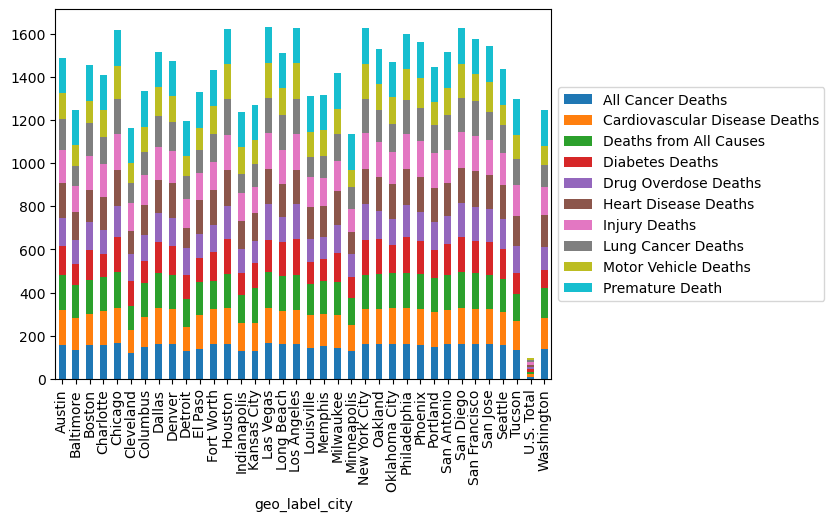

In [11]:
ax = pivot_table.plot(kind='bar', stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Data PreProcessing

In [12]:
data.isnull().sum()

metric_item_label                   0
metric_cat_label                    0
metric_subcat_label                 0
metric_item_label_subtitle          0
metric_cat_item_yaxis_label         0
metric_source_desc_label_fn         0
geo_label_city                      0
geo_label_state                  1097
geo_label_citystate                 0
geo_fips_code                    1097
value                             770
date_label                          0
geo_label_proxy_or_real             0
geo_label_proxy_footnote       133002
geo_fips_desc                       0
date_label_proxy_or_real            0
date_label_proxy_footnote      104164
value_ci_flag_yesno                 0
value_95_ci_low                 54914
value_95_ci_high                54904
value_90_ci_low                148292
value_90_ci_high               148292
geo_strata_region                1097
geo_strata_poverty               1097
geo_strata_Population            1097
geo_strata_PopDensity            1097
geo_strata_S

Deleting the columns that contain more than 50% (74'146) missing values.

In [13]:
missing_values = data.isnull().mean()
columns_to_drop = list(missing_values[missing_values > 0.5].index)
data = data.drop(columns_to_drop, axis=1)
columns_to_drop

['geo_label_proxy_footnote',
 'date_label_proxy_footnote',
 'value_90_ci_low',
 'value_90_ci_high',
 'strata_race_sex_label']

Detect Numerical and Categorical Features

In [14]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns
num_features, cat_features

(Index(['geo_fips_code', 'value', 'date_label', 'value_95_ci_low',
        'value_95_ci_high'],
       dtype='object'),
 Index(['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
        'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
        'metric_source_desc_label_fn', 'geo_label_city', 'geo_label_state',
        'geo_label_citystate', 'geo_label_proxy_or_real', 'geo_fips_desc',
        'date_label_proxy_or_real', 'value_ci_flag_yesno', 'geo_strata_region',
        'geo_strata_poverty', 'geo_strata_Population', 'geo_strata_PopDensity',
        'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label'],
       dtype='object'))

Filling in the missing spots (KNN in numerical and Simple for numerical)

In [15]:
imputerKNN = KNNImputer(n_neighbors=3)
imputerCat = SimpleImputer(strategy='most_frequent')
imputerNum = SimpleImputer(strategy='median')

In [16]:
data[cat_features] = imputerCat.fit_transform(data[cat_features])


In [17]:
np.var(data)

/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


geo_fips_code       2.882597e+12
value               1.852533e+07
date_label          9.687801e+00
value_95_ci_low     3.037651e+06
value_95_ci_high    4.176156e+06
dtype: float64

Since all have high variance but not "date_label" we use median for datasets with high variance and mean imputation for data with low variance.(But "date_label" has no missing value so using median for all)

In [18]:
data[num_features] = imputerNum.fit_transform(data[num_features])

In [19]:
data.isnull().sum()

metric_item_label              0
metric_cat_label               0
metric_subcat_label            0
metric_item_label_subtitle     0
metric_cat_item_yaxis_label    0
metric_source_desc_label_fn    0
geo_label_city                 0
geo_label_state                0
geo_label_citystate            0
geo_fips_code                  0
value                          0
date_label                     0
geo_label_proxy_or_real        0
geo_fips_desc                  0
date_label_proxy_or_real       0
value_ci_flag_yesno            0
value_95_ci_low                0
value_95_ci_high               0
geo_strata_region              0
geo_strata_poverty             0
geo_strata_Population          0
geo_strata_PopDensity          0
geo_strata_Segregation         0
strata_race_label              0
strata_sex_label               0
dtype: int64

In [20]:
#data[num_features] = imputerKNN.fit_transform(data[num_features])


No more missing values. Now is time for data analysis and feature selection

In [21]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high
count,1.482920e+05,148292.000000,148292.000000,148292.000000,148292.000000
mean,2.880748e+06,826.205087,2015.227996,303.835831,370.779665
std,1.691543e+06,4293.319708,3.112534,1399.674150,1642.145192
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320
25%,8.200000e+05,10.913543,2013.000000,15.860769,24.484818
50%,2.938000e+06,26.743773,2015.000000,23.259248,34.061614
75%,4.748000e+06,76.710433,2018.000000,36.684472,52.822604
max,5.553000e+06,99408.000000,2020.000000,22650.600880,29193.761110


For value_95_ci_low and value_95_ci_high, the mean has drastically changed. Maybe use another filling type.

Now encode Categorical Features:

In [22]:
data.values.shape

(148292, 25)

In [23]:
X = data.values
y = data['metric_item_label'].values

In [24]:
column_names = ['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
        'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
        'metric_source_desc_label_fn', 'geo_label_city', 'geo_label_state',
        'geo_label_citystate', 'geo_fips_code', 'value', 'date_label',
        'geo_label_proxy_or_real', 'geo_fips_desc', 'date_label_proxy_or_real',
        'value_ci_flag_yesno', 'value_95_ci_low', 'value_95_ci_high',
        'geo_strata_region', 'geo_strata_poverty', 'geo_strata_Population',
        'geo_strata_PopDensity', 'geo_strata_Segregation', 'strata_race_label',
        'strata_sex_label']

In [25]:
X = pd.DataFrame(X, columns=column_names)
y = pd.Series(y, name='metric_item_label')

In [26]:
num_cols = X.columns.drop(data.select_dtypes(include=['object']).columns)
cate_cols = X.columns.drop(X.select_dtypes(include=['float64', 'int64']).columns).drop('metric_item_label')

In [27]:
cate_cols

Index(['metric_cat_label', 'metric_subcat_label', 'metric_item_label_subtitle',
       'metric_cat_item_yaxis_label', 'metric_source_desc_label_fn',
       'geo_label_city', 'geo_label_state', 'geo_label_citystate',
       'geo_fips_code', 'value', 'date_label', 'geo_label_proxy_or_real',
       'geo_fips_desc', 'date_label_proxy_or_real', 'value_ci_flag_yesno',
       'value_95_ci_low', 'value_95_ci_high', 'geo_strata_region',
       'geo_strata_poverty', 'geo_strata_Population', 'geo_strata_PopDensity',
       'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label'],
      dtype='object')

In [28]:
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[cate_cols])
col_names = encoder.get_feature_names_out(cate_cols)
X = pd.DataFrame(X_encoded.toarray(), columns=col_names)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


: 

: 

# Feature Selection


In [ ]:
sc = StandardScaler()

In [ ]:
X_scaled = sc.fit_transform(X)
X_scaled_abs = abs(X_scaled)

Using Lasso

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso_coefficiants = lasso.coef_ 

In [ ]:
coef = np.abs(lasso.coef_)
coef_sorted = np.argsort(coef)[::-1]

feature_names = data.columns[coef_sorted[:15]]

Text(0.5, 1.0, 'Top 15 Features Selected by Lasso')

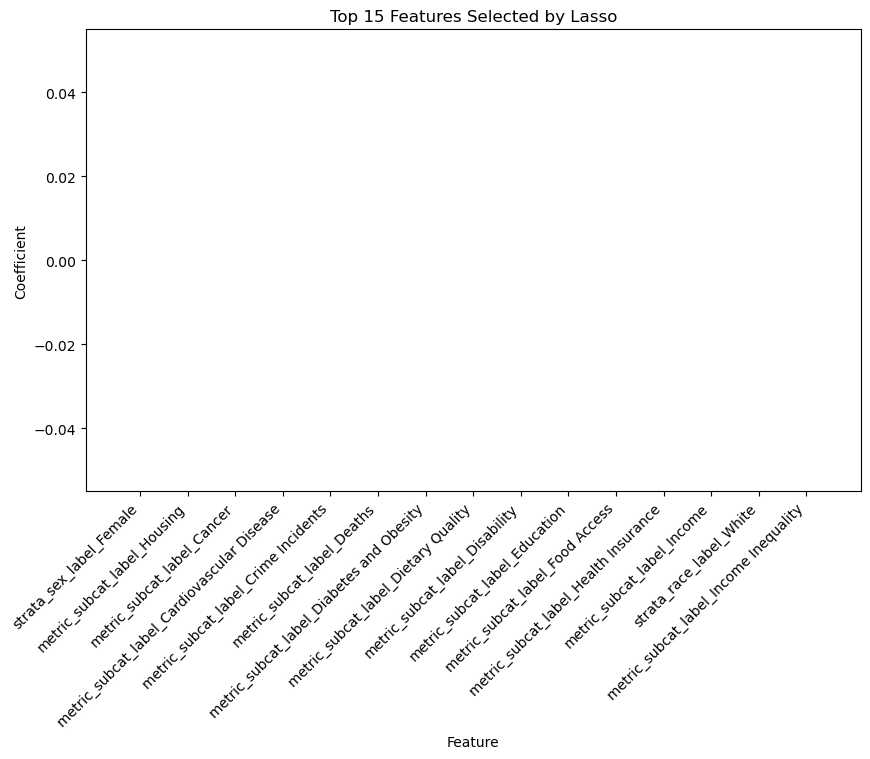

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(feature_names, coef[coef_sorted[:15]])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 15 Features Selected by Lasso')

Random Forest Method

In [1]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Get the indices of the top 15 features
indices = (-importances).argsort()[:15]
sorted_idx = indices[np.argsort(importances[indices])[::-1]]

# Get feature names
feature_names = X_scaled.columns[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(indices)), importances[indices])
plt.xticks(np.arange(len(indices)), feature_names, rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 15 Features Selected by Random Forest")
plt.tight_layout()

NameError: name 'RandomForestClassifier' is not defined

Pearson

Text(0.5, 1.0, '15 Best Features Selected by Pearson Correlation (Descending Order)')

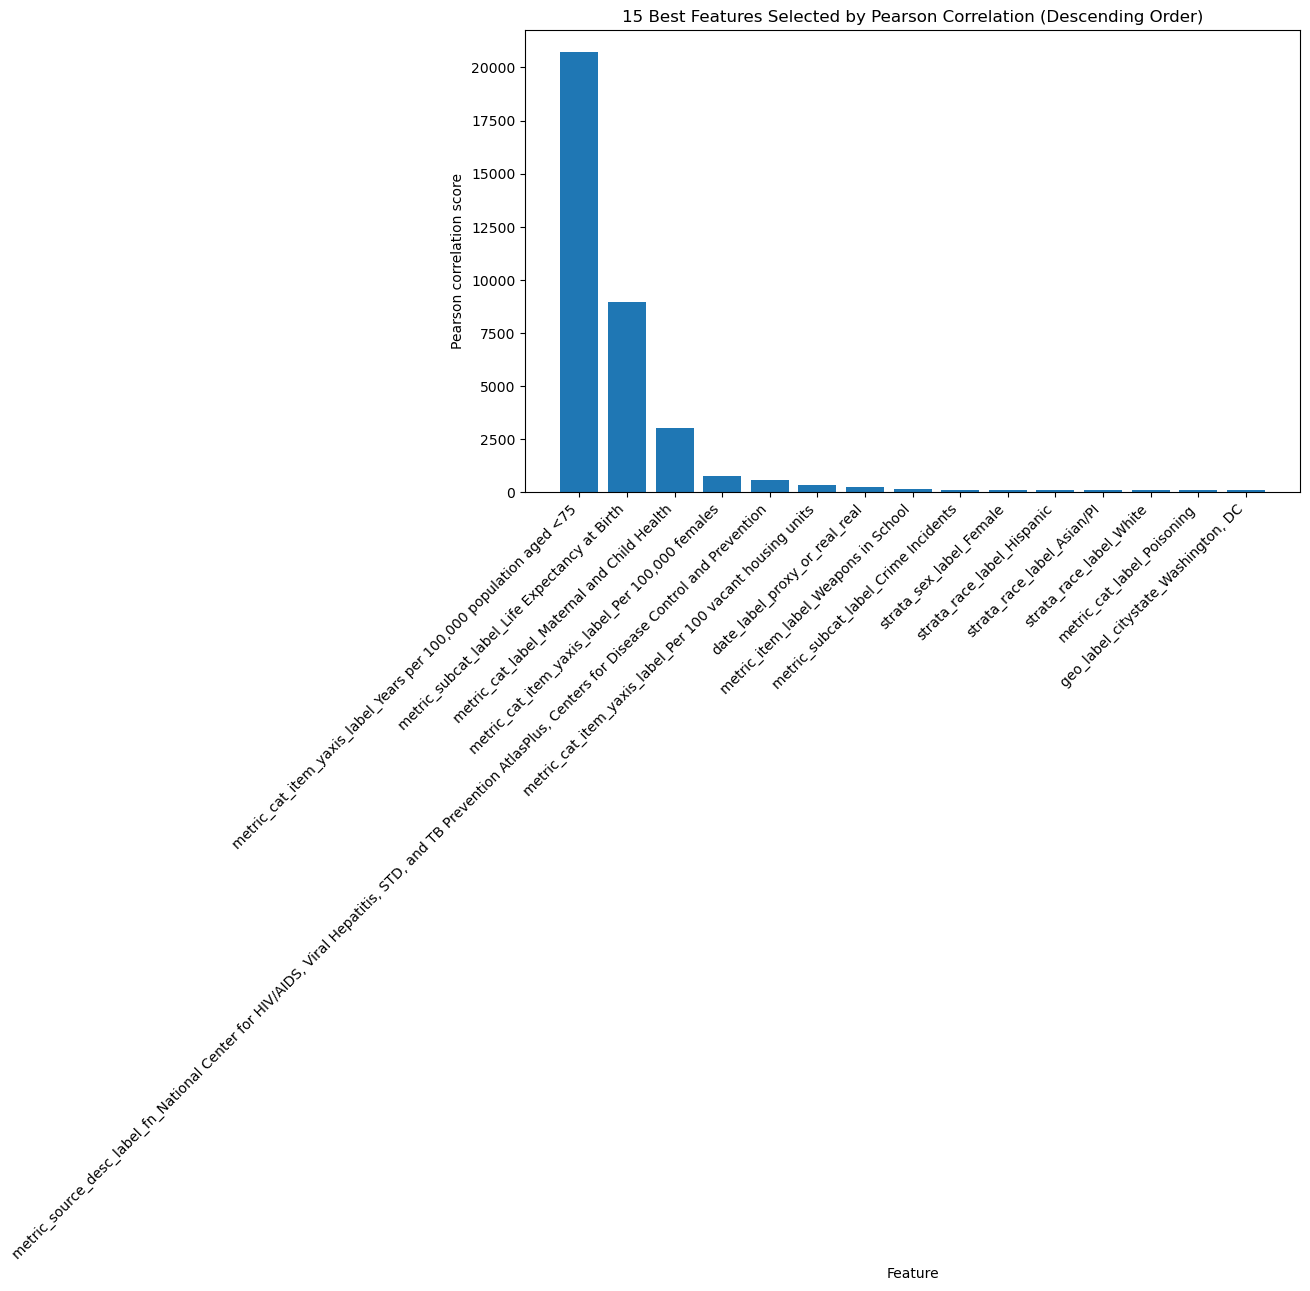

In [ ]:
correlations = np.abs(np.corrcoef(X.T, y)[:4, 4])

pearson_selector = SelectKBest(score_func=f_regression, k=15)
pearson_selector.fit(X, y)
pearson_selected = pearson_selector.get_support(indices=True)

indices = np.argsort(pearson_selector.scores_[pearson_selected])[::-1]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(15), pearson_selector.scores_[pearson_selected][indices])
plt.xticks(np.arange(15), data.columns[pearson_selected][indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Pearson correlation score")
plt.title("15 Best Features Selected by Pearson Correlation (Descending Order)")

Compare Both

In [ ]:
overlap = set()

# Data Visualisation

In [ ]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,...,geo_strata_PopDensity_Lower pop. density (<10k per sq mi),geo_strata_Segregation_Less Segregated (<50%),strata_race_label_American Indian/Alaska Native,strata_race_label_Asian,strata_race_label_Asian/PI,strata_race_label_Black,strata_race_label_Hispanic,strata_race_label_White,strata_sex_label_Female,strata_sex_label_Male
count,1.482920e+05,1.482920e+05,1.482920e+05,1.482920e+05,1.482920e+05,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,...,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000
mean,9.726363e-16,-9.622103e-17,2.833045e-14,-3.602731e-13,-1.254504e-14,0.002670,0.002670,0.002670,0.002670,0.035882,...,0.807245,0.612919,0.033994,0.034223,0.076464,0.171526,0.151586,0.174993,0.161364,0.184521
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.051607,0.051607,0.051607,0.051607,0.185996,...,0.394464,0.487084,0.181214,0.181802,0.265740,0.376970,0.358620,0.379962,0.367868,0.387910
min,-1.436080e+00,-1.926519e-01,-1.679665e+00,-3.193887e-01,-2.212515e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.220463e+00,-1.899212e-01,-7.158167e-01,-2.058388e-01,-2.117952e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.070453e-02,-1.862407e-01,-7.325122e-02,-2.058388e-01,-2.117952e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.099927e+00,-1.745395e-01,8.905970e-01,-1.875005e-01,-1.893907e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.575466e+00,2.296164e+01,1.533162e+00,1.595847e+01,1.754127e+01,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
